### Paso 0: Habilitar acceso IMAP y generar credenciales

Lo primero que se debe realizar es "Habilitar el acceso IMAP" en la sección "Acceso IMAP" de [Gmail](https://mail.google.com/mail/u/0/#settings/fwdandpop/), esto nos permitirá acceder a nuestra cuenta desde cualquier dispositivo.
<br>
<br>
Lo segundo es generar una [contraseña de aplicación](https://myaccount.google.com/apppasswords), la cual utilizaremos para loguearnos a Gmail desde Python.
<br>

In [1]:
import imaplib
import email
from email.header import decode_header

import pandas as pd
from tqdm import tqdm

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud, STOPWORDS

### Paso 1: Acceder a Gmail con las credenciales

In [65]:
user, password = "sandreke99@gmail.com", "tupassword"

imap_url ='imap.gmail.com'
my_mail = imaplib.IMAP4_SSL(imap_url)
my_mail.login(user, password)

('OK', [b'sandreke99@gmail.com authenticated (Success)'])

In [66]:
# Seleccionar todos los correos de la bandeja de entrada
my_mail.select('Inbox')

('OK', [b'2168'])

In [13]:
total_correos = int(my_mail.select('Inbox')[1][0].decode('utf-8'))
total_correos

2168

### Paso 2: Obtener correos electrónicos

In [87]:
email_df = pd.DataFrame(columns=['Date','From','Subject'], index=range(total_correos,0,-1))

for i in tqdm(range(total_correos, 0, -1)):
    data = my_mail.fetch(str(i),'(UID RFC822)')
    arr = data[1][0]
    if isinstance(arr, tuple):
        try: msg = email.message_from_string(str(arr[1],'utf-8'))
        except: msg = email.message_from_string(str(arr[1],'latin-1'))
        new_row = pd.Series({"Date":msg['Date'] , "From":msg['from'], "Subject":msg['subject']})
    email_df = email_df.append(new_row, ignore_index=True)
    
email_df = email_df.dropna(how='all').reset_index(drop=True) # Limpiar filas vacías
email_df

100%|██████████████████████████████████████████████████████████████████████████████| 2168/2168 [17:08<00:00,  2.11it/s]


,Date,From,Subject
0,"Fri, 08 Sep 2023 22:29:42 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
1,"Fri, 8 Sep 2023 17:03:05 -0500 (CDT)",TeePublic Artist Team <community@teepublic.com>,Limited Edition Color: Raspberry Sorbet
2,"Fri, 08 Sep 2023 21:51:03 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
3,"Fri, 08 Sep 2023 21:23:05 +0000 (UTC)",ConvertKit <help@convertkit.com>,Your week with ConvertKit
4,"Fri, 08 Sep 2023 15:14:18 +0000","""Redbubble"" <heythere@m.redbubble.com>",=?utf-8?B?SGFzdGEgdW4gLTQwwqAlIGVuIHRvZG8gbG8g...
...,...,...,...
2163,"Wed, 5 Dec 2018 07:32:21 -0800","""Instagram"" <no-reply@mail.instagram.com>","sandreke99, mira las nuevas publicaciones de c..."
2164,"Fri, 21 Sep 2018 00:00:04 -0700","""Instagram"" <no-reply@mail.instagram.com>","sandreke99, we've found some accounts you migh..."
2165,"Sun, 16 Sep 2018 23:36:09 -0700","""Instagram"" <no-reply@mail.instagram.com>",=?UTF-8?B?c2FuZHJla2U5OSwgZWNo?=\r\n =?UTF-8?B...
2166,"Tue, 26 Jun 2018 10:17:40 -0700","""Instagram"" <no-reply@mail.instagram.com>",Confirm your email address for Instagram


##### Como se están extrayendo una gran cantidad de correos, el proceso tiende a demorarse un poco (2168 mails ~ 17min). Por esa razón, guardamos el dataframe email_df en un csv.

In [89]:
email_df.to_csv('Data/email_df.csv', index=False, encoding='utf-8')

##### Nota:  Usando <b>msg.keys()</b> se pueden observar todos las variables posibles a extraer, la razón de por qué nos quedamos con 3 se debe a que son las que mejor se pueden explotar. Un sample de valores de todas las variables está en el archivo <b>msg_keys.txt</b> de la carpeta [Resources](https://github.com/Sandreke/Gmail-Data-Analysis-with-Python-and-PowerBI/tree/main/Resources)

In [88]:
print(msg.keys())

['Delivered-To', 'Received', 'X-Received', 'ARC-Seal', 'ARC-Message-Signature', 'ARC-Authentication-Results', 'Return-Path', 'Received', 'Received-SPF', 'Authentication-Results', 'DKIM-Signature', 'X-Google-DKIM-Signature', 'X-Gm-Message-State', 'X-Google-Smtp-Source', 'MIME-Version', 'X-Received', 'Date', 'Reply-To', 'X-Google-Id', 'Feedback-ID', 'X-Notifications', 'Message-ID', 'Subject', 'From', 'To', 'Content-Type']


### Paso 3: Limpieza y transformación de datos

##### 3.1. Columna *Date*

In [90]:
def limpiar_fecha(x):
    if ',' not in x: x = ', ' + x
    if '(' in x: x = ' '.join(x.split(' ')[:-1])
    x = ' '.join(x.split(' ')[:-1])
    return x

In [94]:
### Transformar Date "Wed, 14 Sep 2022 17:38:23 +0000 (UTC)" 
# Obtener columna 'H_M_S'
email_df['Date'] = email_df['Date'].apply(lambda x: limpiar_fecha(x)) # Se obtiene "Wed, 14 Sep 2022 17:38:23"
email_df['Date'] = email_df['Date'].str.split(', ').str[-1]           # Se obtiene "14 Sep 2022 17:38:23"
email_df['H_M_S'] = email_df['Date'].apply(lambda x: x[-8:])          # Se obtiene "17:38:23"

# Obtener columna 'Hour'
email_df['Hour'] = email_df['H_M_S'].apply(lambda x: x[:2]+'h-'+str(int(x[:2])+1).zfill(2)+'h')    # Se obtiene "17h-18h"

# Obtener columna 'Date'
email_df['Date'] = email_df['Date'].apply(lambda x: x[:-9] if len(x[:-9])==11 else '0'+x[:-9] )    # Se obtiene "14 Sep 2022"
email_df['Date'] = pd.to_datetime(email_df['Date'], format='%d %b %Y')                             # Se obtiene "2022-09-14"

# Obtener columna 'WeekDay'
email_df['WeekDay'] = email_df['Date'].dt.strftime('%A')                                           # Se obtiene "Wednesday"  

email_df.head()

,Date,From,Subject,H_M_S,Hour,WeekDay
0,2023-09-08,Google <no-reply@accounts.google.com>,Alerta de seguridad,22:29:42,22h-23h,Friday
1,2023-09-08,TeePublic Artist Team <community@teepublic.com>,Limited Edition Color: Raspberry Sorbet,17:03:05,17h-18h,Friday
2,2023-09-08,Google <no-reply@accounts.google.com>,Alerta de seguridad,21:51:03,21h-22h,Friday
3,2023-09-08,ConvertKit <help@convertkit.com>,Your week with ConvertKit,21:23:05,21h-22h,Friday
4,2023-09-08,"""Redbubble"" <heythere@m.redbubble.com>",=?utf-8?B?SGFzdGEgdW4gLTQwwqAlIGVuIHRvZG8gbG8g...,15:14:18,15h-16h,Friday


##### 3.2. Columna *From* y *Subject*

In [95]:
def obtener_correo_de_from(x):
    x_mod = x.split('<')[-1].split('>')[0]
    return x_mod

def obtener_nombre_de_from(x):
    text, encoding = decode_header(x)[0]
    if not encoding and isinstance(text, str):
        text = ' '.join(text.split(' ')[:-1])
    else:
        text = text.decode('utf-8', errors='ignore')
        
    text = text.replace('"', '')
    return text

def limpiar_subject(x):
    if x:
        text, encoding = decode_header(x)[0]
        try: text = text.decode('utf-8', errors='ignore')
        except: pass
    else: text=x
    return text

In [100]:
email_df['Mail'] = email_df['From'].apply(lambda x: obtener_correo_de_from(x))
email_df['Name'] = email_df['From'].apply(lambda x: obtener_nombre_de_from(x))
email_df['Subject'] = email_df['Subject'].apply(lambda x: limpiar_subject(x))
email_df = email_df.drop(columns=['From'])[['Date','H_M_S','Hour','WeekDay','Mail','Name','Subject']]
email_df.head()

,Date,H_M_S,Hour,WeekDay,Mail,Name,Subject
0,2023-09-08,22:29:42,22h-23h,Friday,no-reply@accounts.google.com,Google,Alerta de seguridad
1,2023-09-08,17:03:05,17h-18h,Friday,community@teepublic.com,TeePublic Artist Team,Limited Edition Color: Raspberry Sorbet
2,2023-09-08,21:51:03,21h-22h,Friday,no-reply@accounts.google.com,Google,Alerta de seguridad
3,2023-09-08,21:23:05,21h-22h,Friday,help@convertkit.com,ConvertKit,Your week with ConvertKit
4,2023-09-08,15:14:18,15h-16h,Friday,heythere@m.redbubble.com,Redbubble,Hasta un -40 % en todo lo que más te gusta.


In [15]:
email_df.to_csv('Data/email_df_final.csv', quotechar='"', sep='|', index=False, encoding='utf-8')

### Paso 4:  Plotear Word Cloud de los asuntos de los correos (columna *Subject*)

In [44]:
# Escalar de 0 a 1 los valores RGB
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

# Asignar colores del logo de Gmail
# guinda (197,34,31), verde (52,168,83), azul (66,133,244), rojo (234,67,53), amarillo (251,188,4)
cdict = {'red':((0.0,inter_from_256(197),inter_from_256(197)),
               (1/5*1,inter_from_256(52),inter_from_256(52)),
               (1/5*3,inter_from_256(66),inter_from_256(66)),
               (1/5*4,inter_from_256(234),inter_from_256(234)),
               (1.0,inter_from_256(251),inter_from_256(251))),
        'green':((0.0, inter_from_256(34), inter_from_256(34)),
               (1/5*1, inter_from_256(168), inter_from_256(168)),
               (1/5*3, inter_from_256(133), inter_from_256(133)),
               (1/5*4, inter_from_256(67), inter_from_256(67)),
               (1.0, inter_from_256(188), inter_from_256(188))),
        'blue':((0.0, inter_from_256(31), inter_from_256(31)),
               (1/5*1, inter_from_256(83), inter_from_256(83)),
               (1/5*3, inter_from_256(244), inter_from_256(244)),
               (1/5*4, inter_from_256(53), inter_from_256(53)),
               (1.0, inter_from_256(4), inter_from_256(4))),}

# Crear paleta customizada de colores
gmail = LinearSegmentedColormap('gmail',segmentdata=cdict)

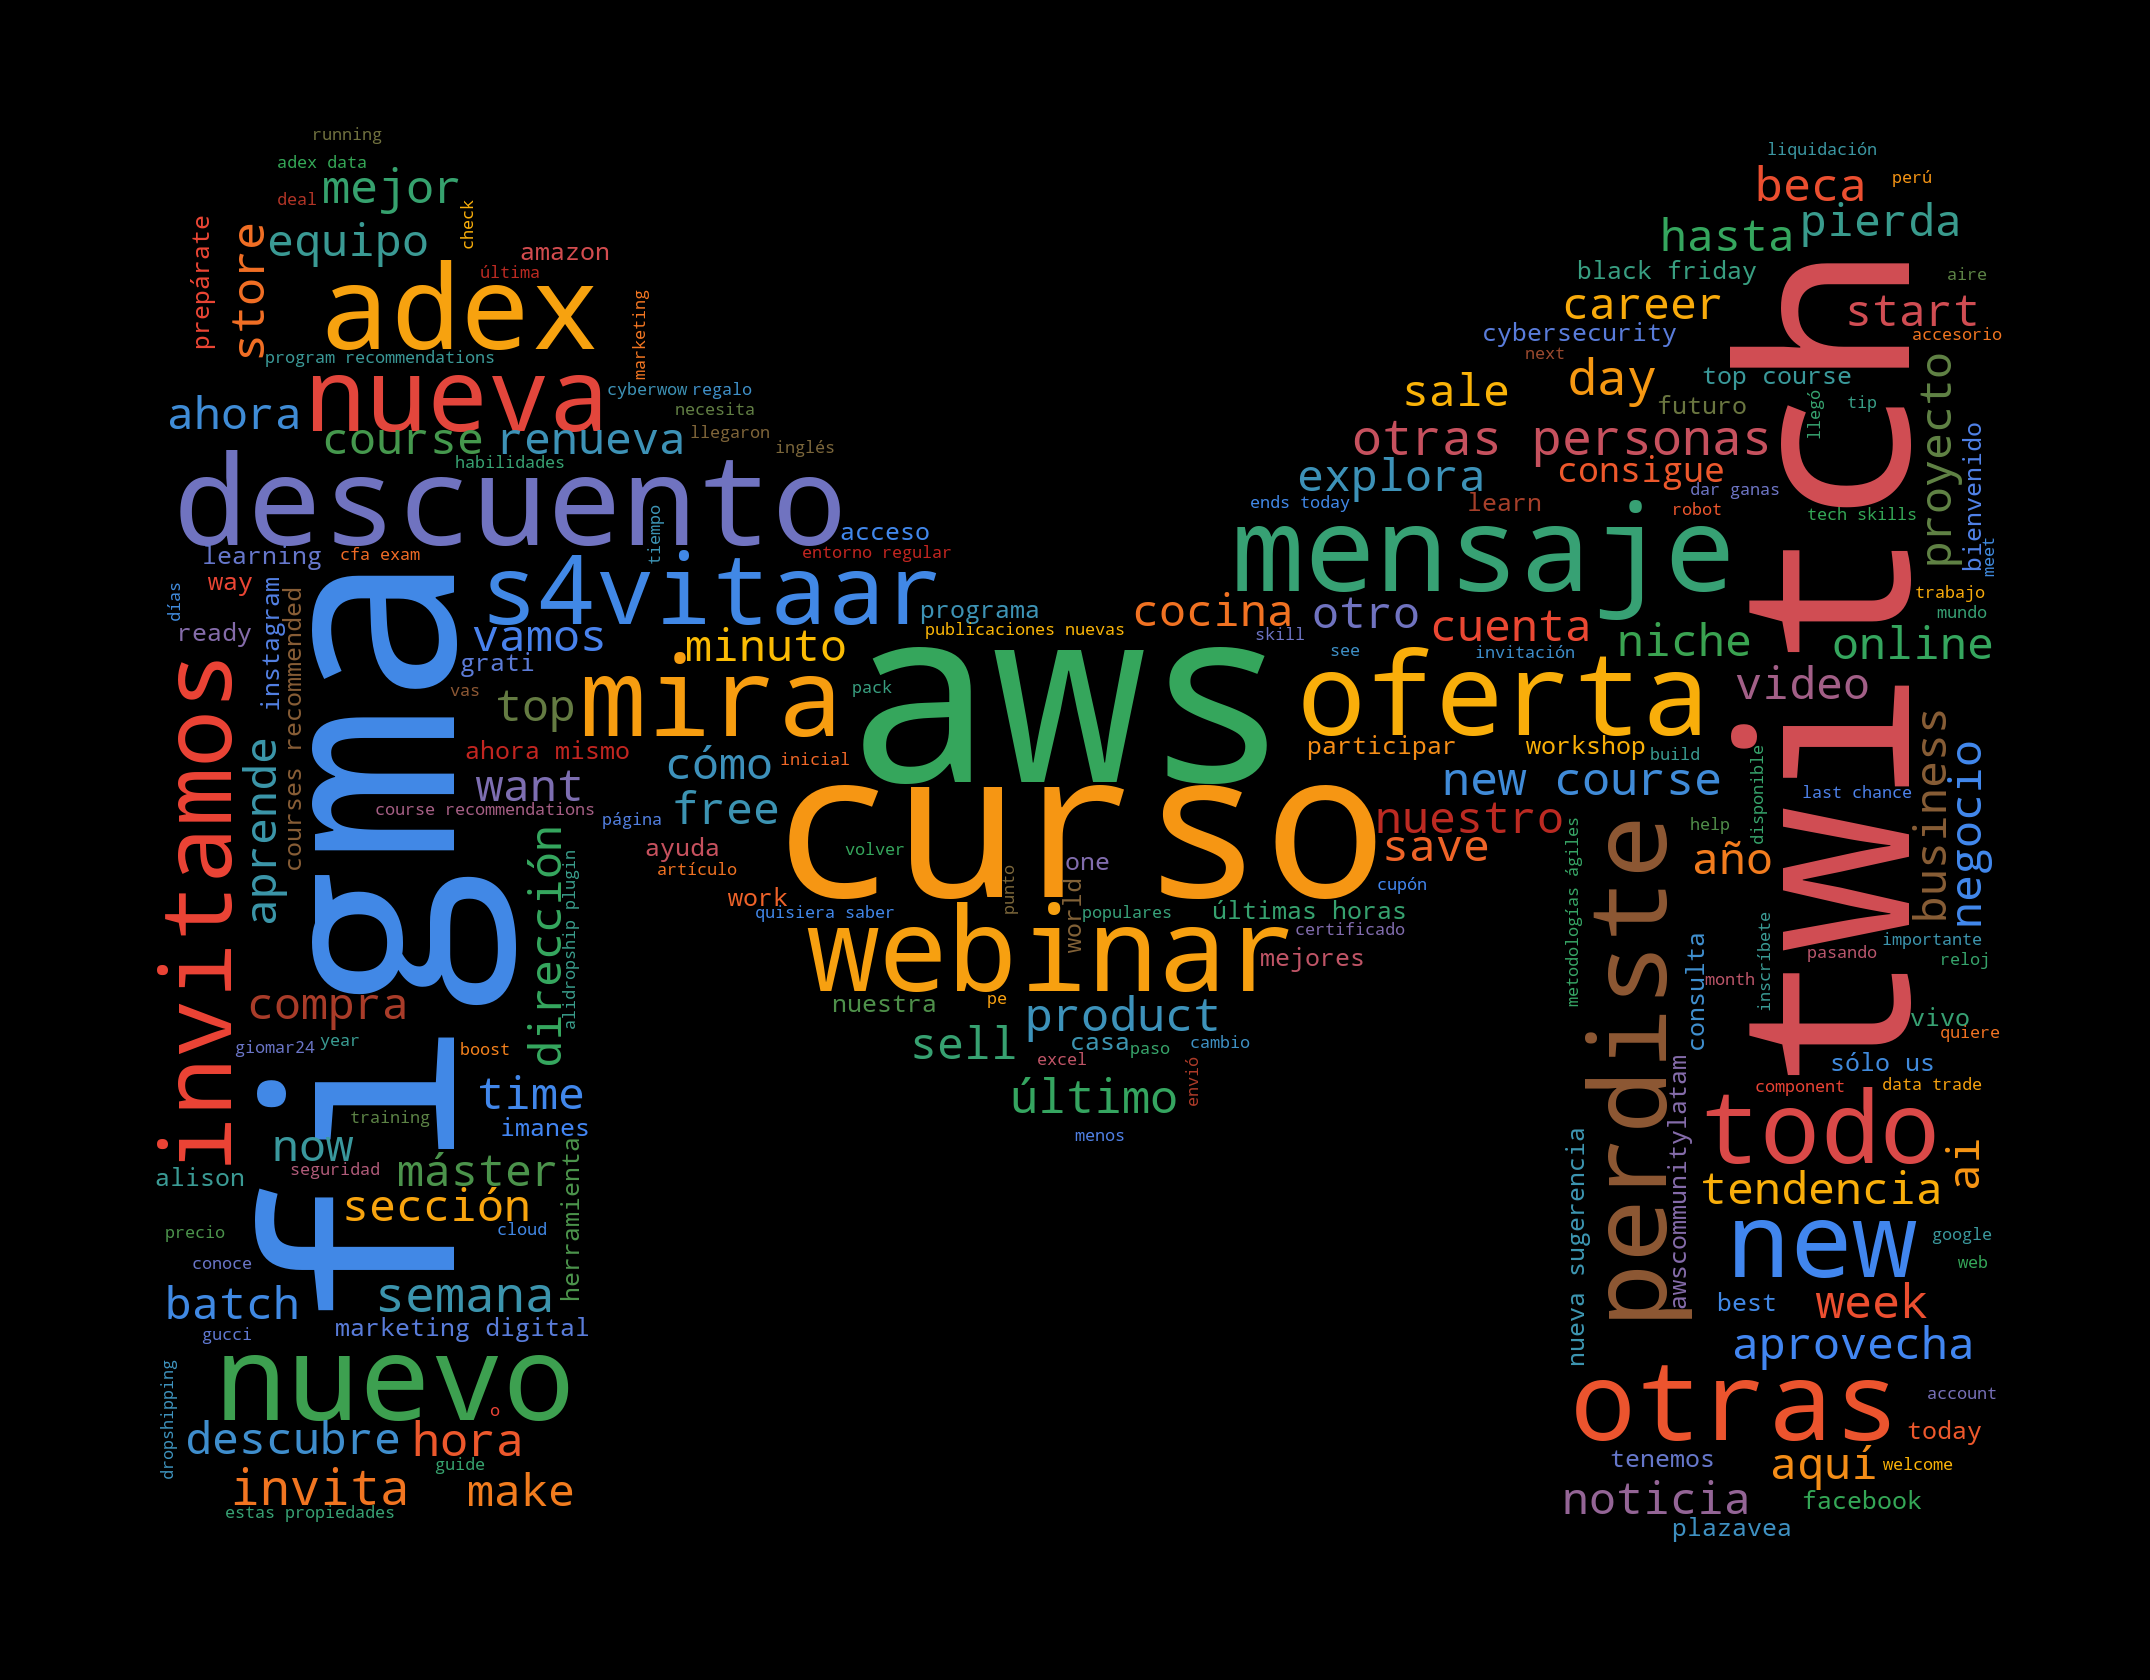

In [45]:
# Crear un string que contendrá todas las palabras
total_subjects = ' '
stopwords = STOPWORDS.update(['al','de','en','tu','s','la','y','que','te','lo','el','la','solo','del','por','qué','que','ha','desde',
                             'por','ya','más','es','con','tus','para','se','los','un','una','las','esto','va','sobre','ti','los',
                             'sandro','agama','está','tienes notificaciones','este','día','hola','hoy'])
mask = np.array(Image.open('Resources/gmail.jpg'))

# Obtener y acumular todas los subjects de los correos
for mensaje in email_df['Subject'].values:
    subjects = str(mensaje).lower().split() # Obtener las palabras en minúscula de cada subject
    for subject in subjects:
        total_subjects = total_subjects + subject + ' ' # Acumular todas los subjects

wordcloud = WordCloud(scale=2.5, width = 1000, height = 800, 
                      background_color ='black',
                      mask = mask,
                      colormap=gmail,
                      stopwords = stopwords, 
                      min_font_size = 6).generate(total_subjects) 

# Plotear la nube de palabras más usadas
wordcloud.to_image()